## Imports

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jaxquantum.codes as jqtb
import jaxquantum as jqt
import jaxquantum.circuits as jqtc
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import numpy as np

plt.style.use('ggplot')

## Check CUDA devs

In [18]:
jax.devices()

[CudaDevice(id=0)]

In [19]:
jax.devices()[0].memory_stats()

{'num_allocs': 1747,
 'bytes_in_use': 72560640,
 'peak_bytes_in_use': 128775936,
 'largest_alloc_size': 44011776,
 'bytes_limit': 112516399104,
 'bytes_reserved': 0,
 'peak_bytes_reserved': 0,
 'largest_free_block_bytes': 0,
 'pool_bytes': 112516399104,
 'peak_pool_bytes': 112516399104}

## Compute overlap of common states

In [20]:
delta = 0.3
gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": 500})
gkp = gkp_qubit.basis["+z"]
fully_mixed = (gkp_qubit.basis["+z"].to_dm() + gkp_qubit.basis["-z"].to_dm())/2
print(jqt.overlap(gkp_qubit.basis["-z"], gkp_qubit.basis["+z"]))
print(jqt.overlap(fully_mixed, gkp_qubit.basis["+z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], gkp_qubit.basis["+z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z"], gkp_qubit.basis["+z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], gkp_qubit.basis["-z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z"], gkp_qubit.basis["-z"]))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], fully_mixed))
print(jqt.overlap(gkp_qubit.common_gates["Z"], fully_mixed))
print(jqt.overlap(gkp_qubit.common_gates["Z_0"], jqt.basis(500, 0)))
print(jqt.overlap(gkp_qubit.common_gates["Z"], jqt.basis(500, 0)))

1.647022857639053e-07
(0.5000000823511431+0j)
(0.929848356770922+0j)
(0.99587454530817+0.00015948913139287663j)
(-0.9211889097289333+0.00018623852672582466j)
(-0.9878484661974499-0.0003423694391258722j)
(0.004329723521050592-9.311926335758714e-05j)
(0.004013039555408295+9.144015385948038e-05j)
(0.45593812776599607+0j)
(0.45593812776599607+0j)


## Declare circuit parameters

In [21]:
kappa_min = 1/30 # 1/us
kappa_max = 1/30 #1/us
T_0_min = 1 #us
T_0_max = 6 #us

In [22]:
N = 125
T = 100
kappa_0 = 1/30
T_0 = 3000/1000
kappas = jnp.expand_dims(jnp.linspace(kappa_min, kappa_max, 1), 1)
T_0s = jnp.expand_dims(jnp.linspace(T_0_min, T_0_max, 20), 1)
kappaTs = kappas @ T_0s.transpose()
deltas = jnp.linspace(0.3, 0.6, 40)
sd_ratios = jnp.linspace(0.5, 5, 50)
times = jnp.linspace(0, T*2*T_0, T+1)

## Sweep circuit parameters

In [23]:
@jax.jit
def sBs_round(initial_state, alphas, phis, thetas, err_prob):
    N = initial_state.space_dims[1]
    reg = jqtc.Register([2, N])

    cirq = jqtc.Circuit.create(reg, layers=[])

    cirq.append(jqtc.Ry(jnp.pi / 2), 0)
    cirq.append(jqtc.CD(N, alphas[0]), [0, 1])
    cirq.append(jqtc.Ry(phis[0]), 0)
    cirq.append(jqtc.Rx(thetas[0]), 0)
    cirq.append(jqtc.CD(N, alphas[1]), [0, 1])
    cirq.append(jqtc.Ry(phis[1]), 0)
    cirq.append(jqtc.Rx(thetas[1]), 0)
    cirq.append(jqtc.CD(N, alphas[2]), [0, 1])
    cirq.append(jqtc.Reset(), 0)

    cirq.append(jqtc.Amp_Damp(N, err_prob, 20), 1)

    res = jqtc.simulate(cirq, initial_state, mode='kraus')
    final_state = res[-1][-1]

    return final_state

In [24]:
def sbs_batch(delta, sd_ratio, err_prob):
    l = jnp.sqrt(2*jnp.pi)
    epsilon = jnp.sinh(delta*delta)*l

    alphas_real = jnp.array([epsilon/2, 0., sd_ratio*epsilon/2, 0., l, 0.])
    alphas_imag = jnp.array([0., -l, 0., epsilon/2, 0., sd_ratio*epsilon/2])
    alphas = alphas_real + alphas_imag * 1.j
    phis = jnp.array([0., 0., 0., 0.])
    thetas = jnp.array([jnp.pi/2, -jnp.pi/2, jnp.pi/2, -jnp.pi/2])
    exp_X = []
    exp_Z = []
    for axis in ["Z", "X"]:
        gkp_qubit = jqtb.GKPQubit({"delta": delta, "N": N})
        gkp = gkp_qubit.basis["+z"] if axis == "Z" else gkp_qubit.basis["+x"]

        initial_state = jqt.basis(2, 0) ^ gkp
        current_state = initial_state

        if axis=="Z":
            exp_Z.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["Z_0"], current_state.ptrace(1))))
        else:
            exp_X.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["X_0"], current_state.ptrace(1))))
        
        for _ in range(T):

            current_state = sBs_round(current_state, alphas[0:3], phis[0:2],
                                      thetas[0:2], err_prob)
            current_state = sBs_round(current_state, alphas[3:6], phis[2:4],
                                      thetas[2:4], err_prob)
            if axis=="Z":
                exp_Z.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["Z_0"], current_state.ptrace(1))))
            else:
                exp_X.append(jnp.real(jqt.overlap(gkp_qubit.common_gates["X_0"], current_state.ptrace(1))))
    
    return jnp.array([exp_Zi / 2 + exp_Xi / 2 for (exp_Zi, exp_Xi) in zip(exp_Z, exp_X)])

In [25]:
def fit_t1(times, amps):
    def exponential(a):
        return jnp.sum((a[0]*jnp.exp(a[1]*times)-amps)**2)
    scipy_res= minimize(exponential, jnp.array([0., 0.]), method="BFGS")
    return scipy_res

In [26]:
sbs = jax.vmap(jax.vmap(sbs_batch, (0, 0, None), 0), (0, 0, None), 0)
fit_t1_vmap = jax.vmap(jax.vmap(fit_t1, (None, 0), 0), (None, 0), 0)

In [27]:
deltas_mg, sd_ratios_mg = jnp.meshgrid(deltas, sd_ratios)

In [28]:
max_t1s = []
max_deltas = []
max_sd_ratios = []

In [29]:
results = []

In [30]:
for j, kappaT in tqdm(enumerate(kappaTs.flatten())):
    err_prob = 1-jnp.exp(-kappaT)
    results.append(jnp.abs(sbs(deltas_mg, sd_ratios_mg, err_prob)))


20it [1:50:32, 331.63s/it]


In [60]:
np.savez(f"./data/best_sbs_results", results=results)

In [31]:
from jax.scipy.optimize import minimize

20it [00:52,  2.62s/it]


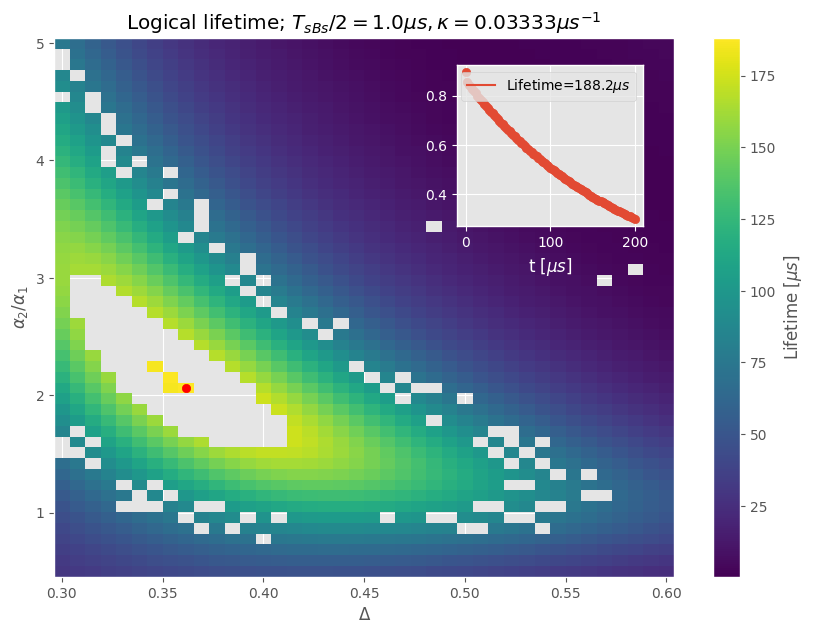

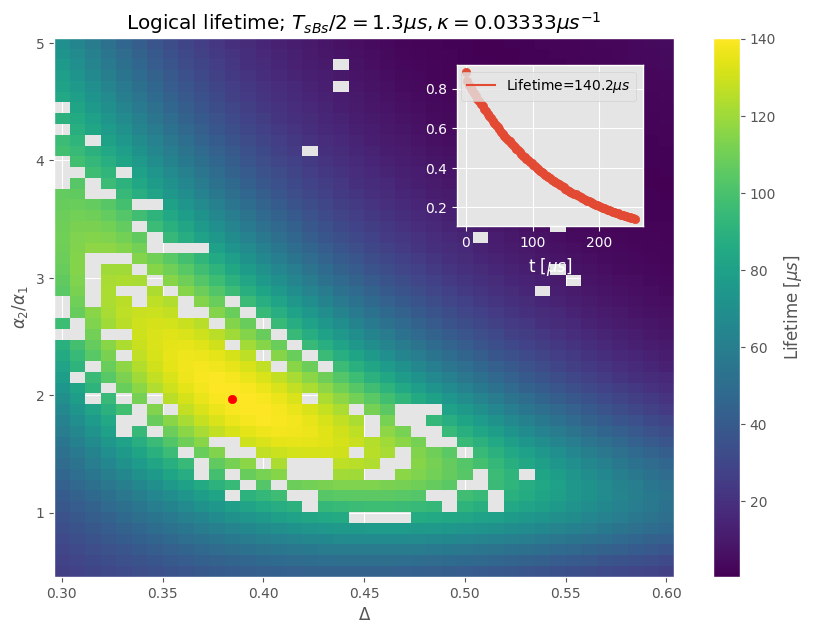

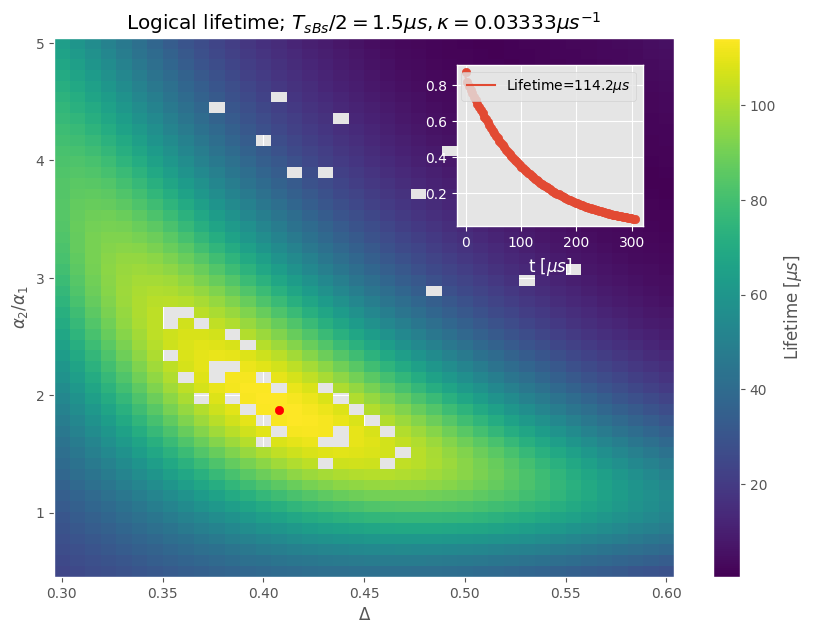

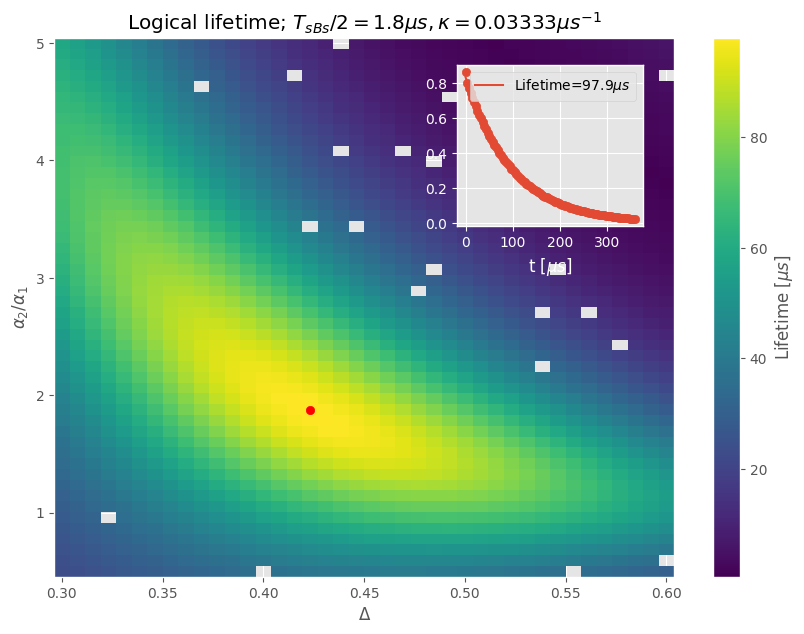

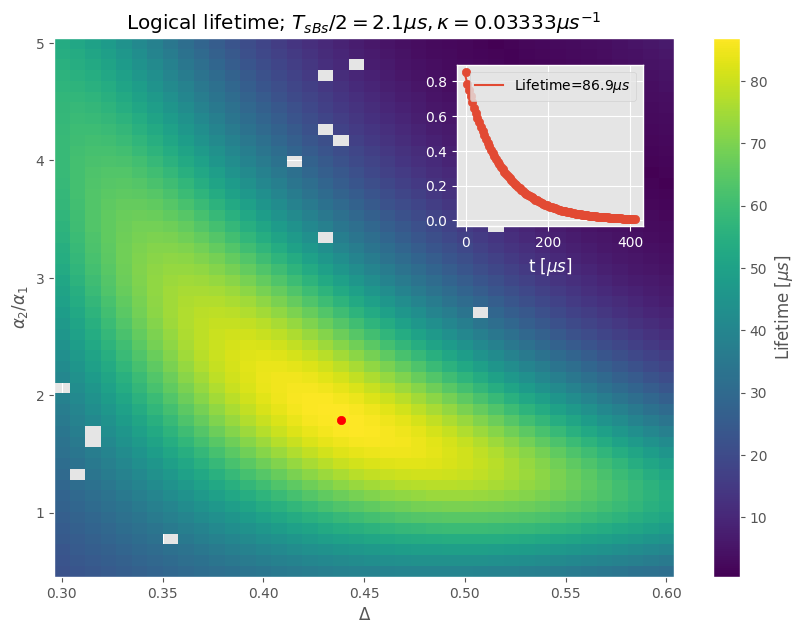

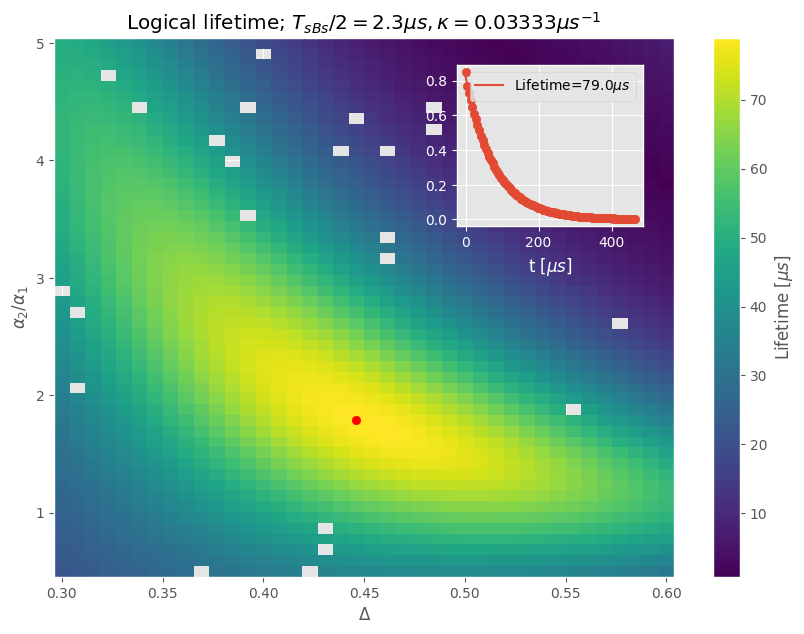

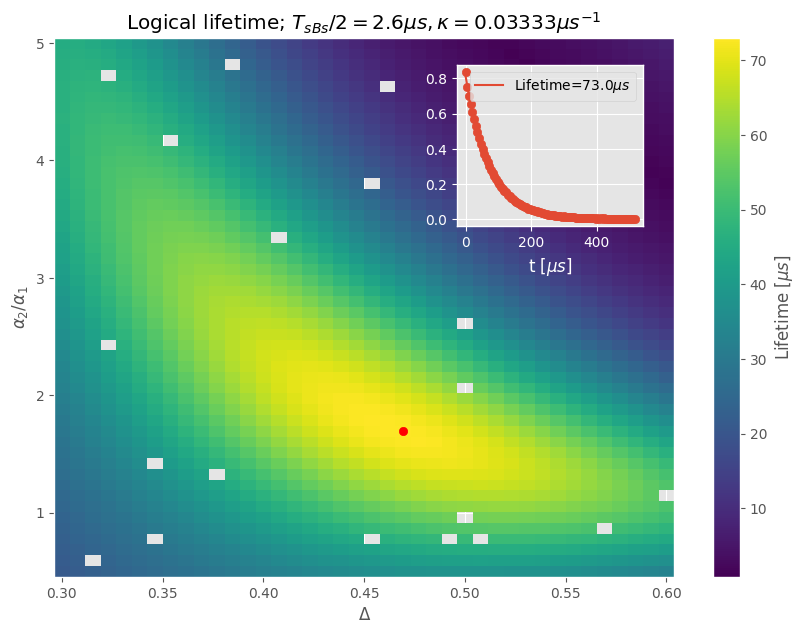

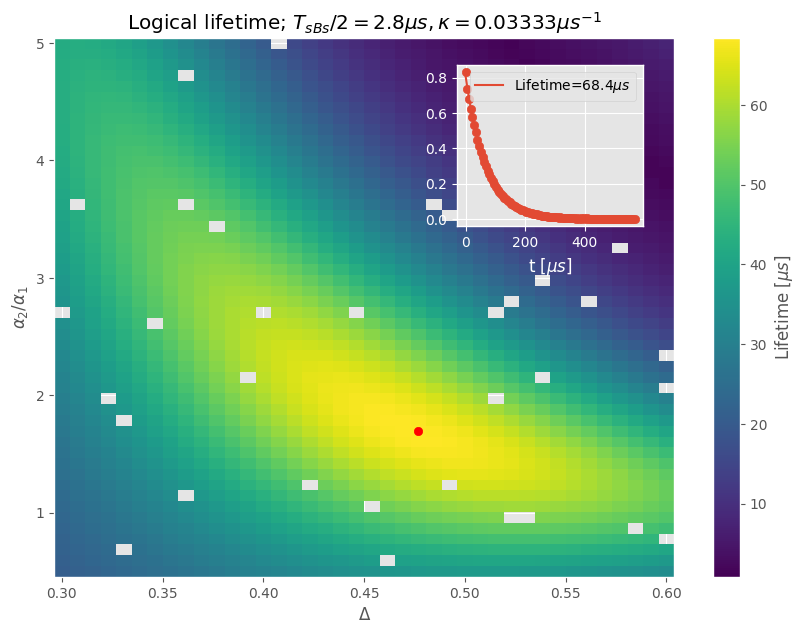

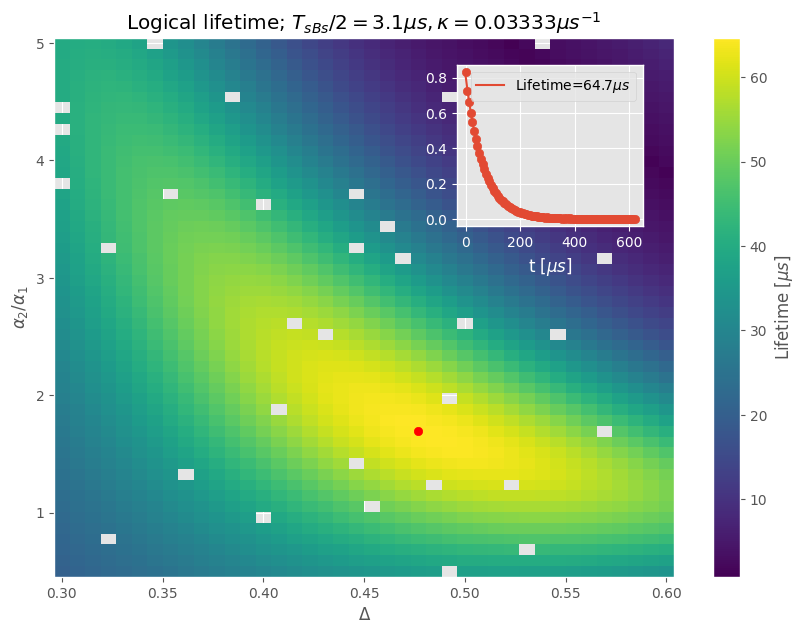

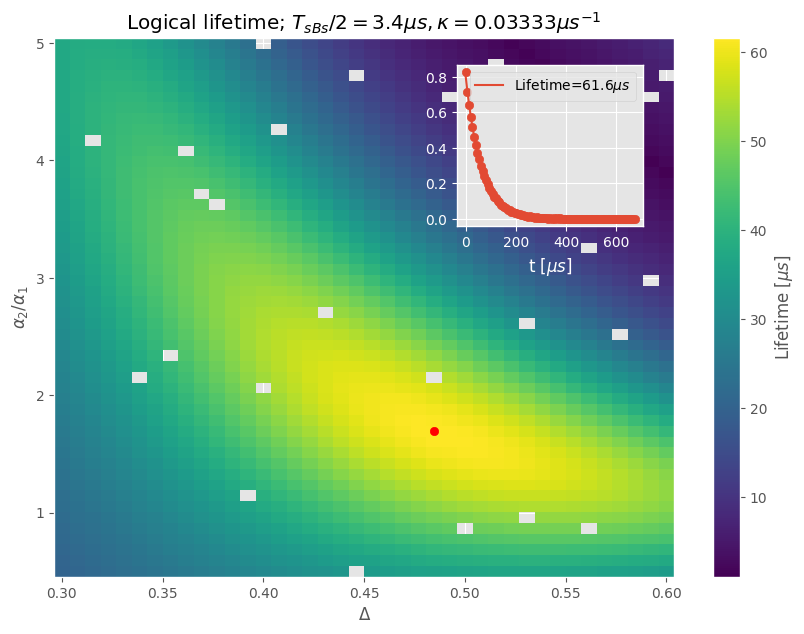

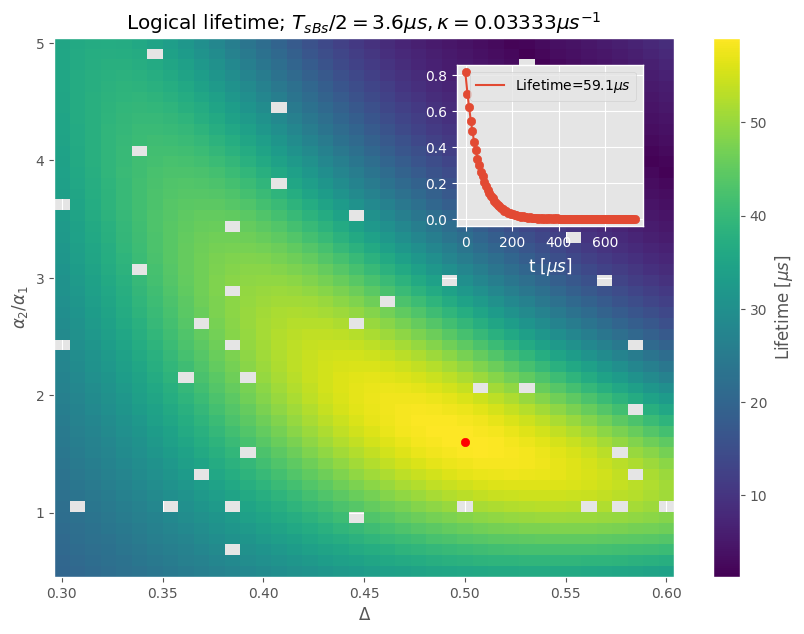

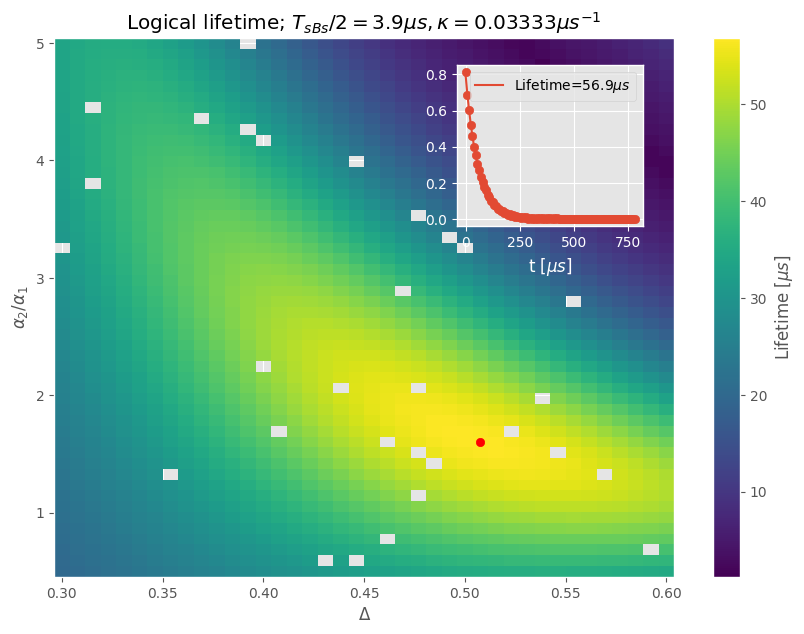

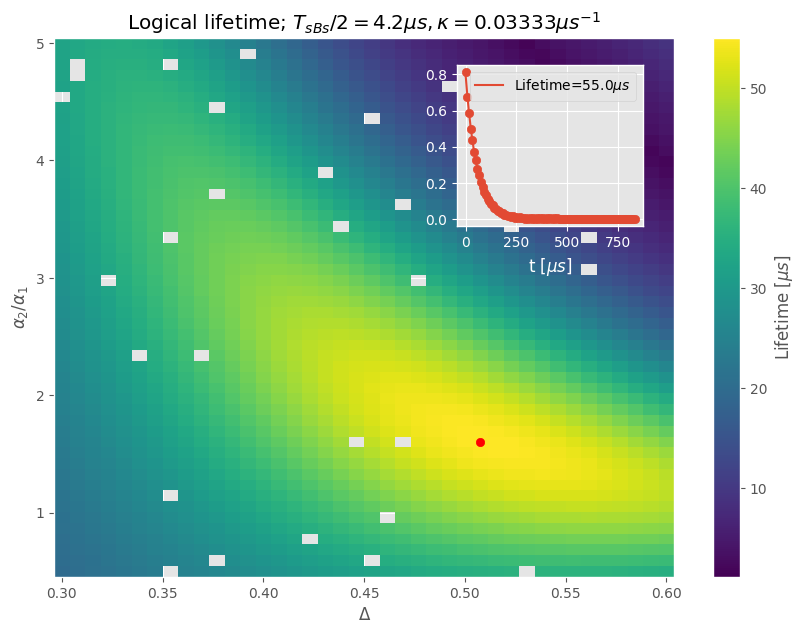

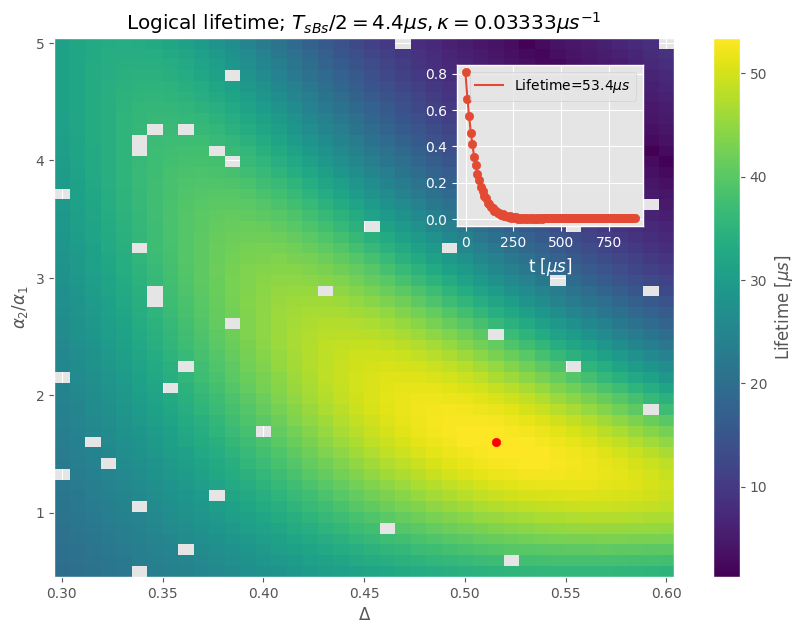

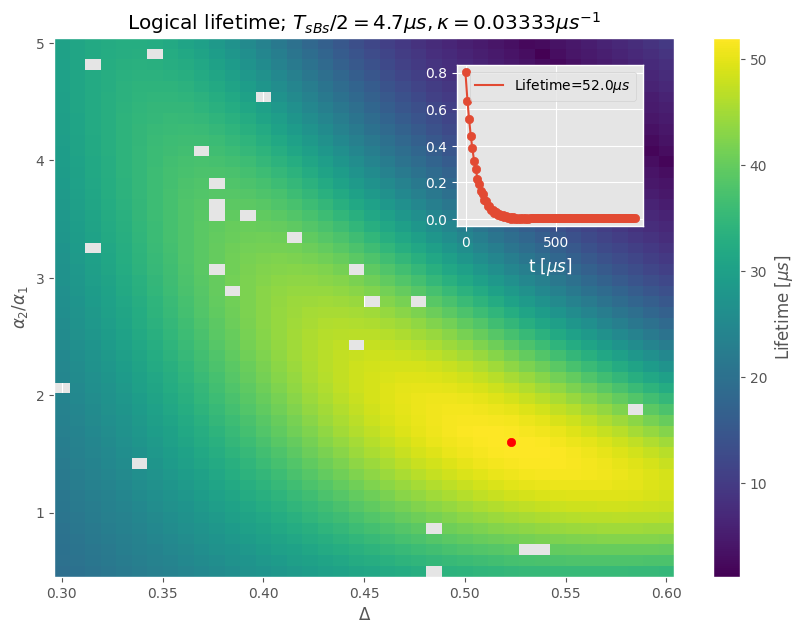

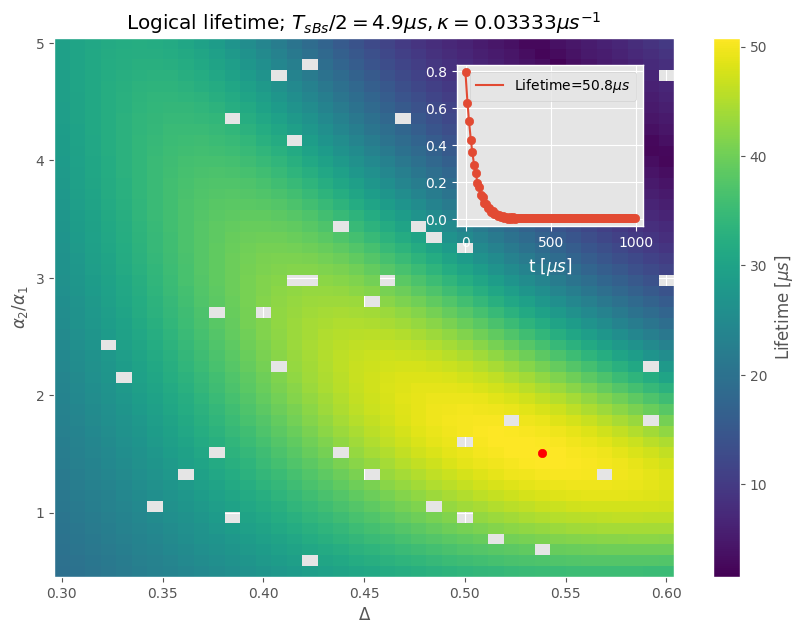

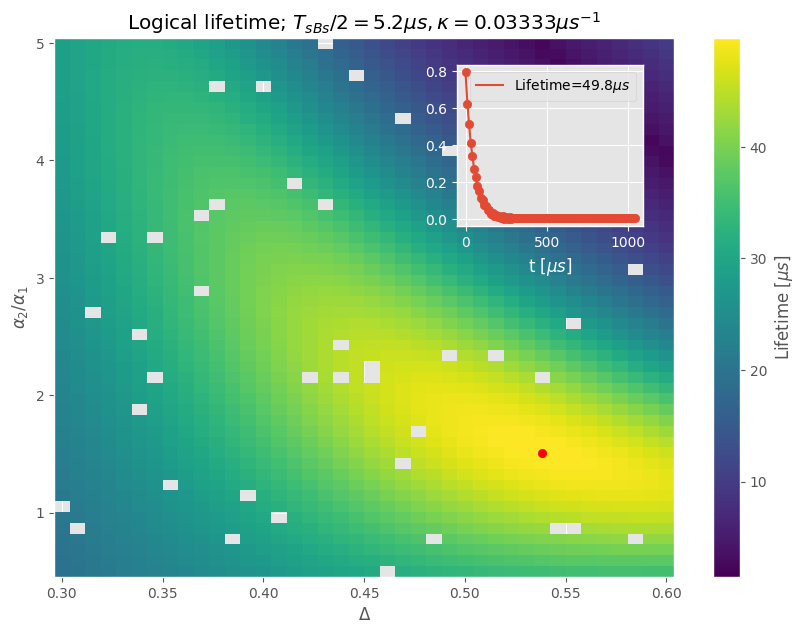

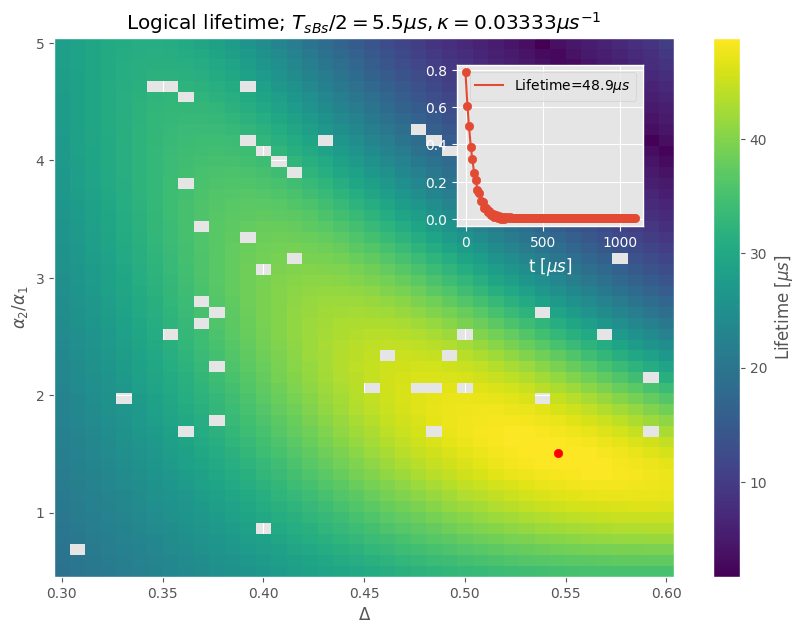

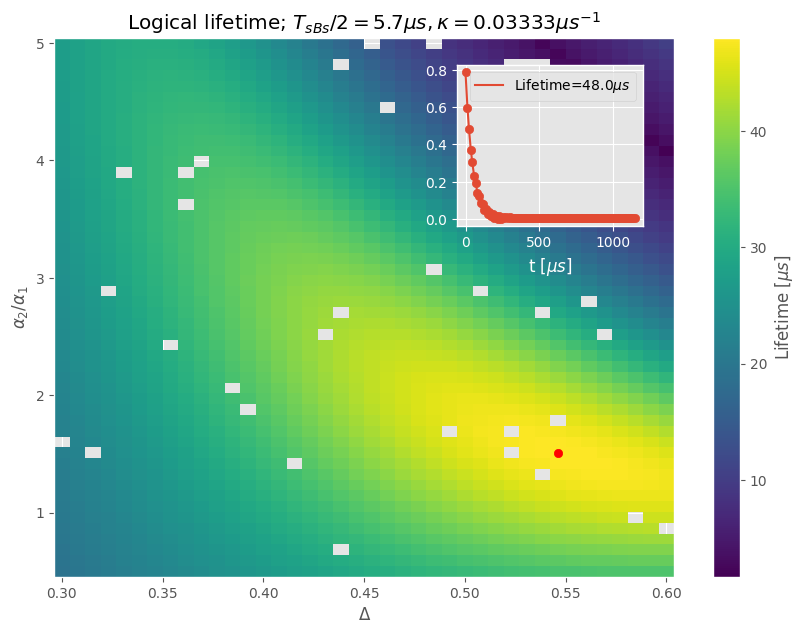

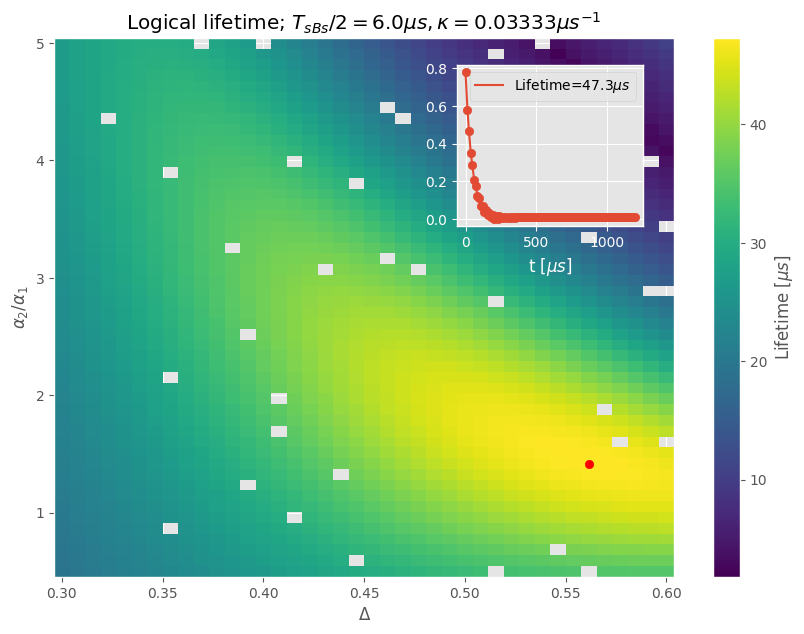

In [34]:
for j, kappaT in tqdm(enumerate(kappaTs.flatten())):
    j_un = jnp.unravel_index(j, kappaTs.shape)
    kappa = kappas[j_un[0]][0]
    T_0 = T_0s[j_un[1]][0]
    times = jnp.linspace(0, T*2*T_0, T+1)
    fit_res = fit_t1_vmap(times, results[j])
    coeff = fit_res.x
    mask = np.array(fit_res.success)
    t1s = -1/coeff[:,:,1]
    err_prob = 1-jnp.exp(-kappaT)
    masking_threshold = 1
    masked_t1s = np.ma.masked_array(np.array(t1s), np.logical_not(mask))
    
    
    max_t1_idx = np.unravel_index(np.argmax(masked_t1s), masked_t1s.shape)
    max_t1 = masked_t1s[max_t1_idx]
    max_t1_delta = deltas_mg[max_t1_idx]
    max_t1_sd_ratio = sd_ratios_mg[max_t1_idx]
    
    fig, ax = plt.subplots(1, figsize=(10, 7))
    handle = ax.pcolormesh(deltas_mg, sd_ratios_mg, masked_t1s, shading='nearest')
    fig.colorbar(handle, ax=ax, label="Lifetime $[\mu s]$")
    ax.scatter(max_t1_delta, max_t1_sd_ratio, color='red')
    ax.set_xlabel(r"$\Delta$")
    ax.set_ylabel(r"$\alpha_2 / \alpha_1$")
    ax.set_title(f"Logical lifetime; $T_{{sBs}}/2 = {T_0:.1f} \mu s, \kappa={kappa:.5f} \mu s^{{-1}} $")
    inset_ax = ax.inset_axes([0.65, 0.65, 0.30, 0.30])
    inset_ax.scatter(times, results[j][max_t1_idx])
    inset_ax.set_xlabel("t $[\mu s]$")
    fit_f = coeff[max_t1_idx][0]*jnp.exp(coeff[max_t1_idx][1]*times)
    inset_ax.xaxis.label.set_color('white')
    inset_ax.tick_params(axis='x', colors='white')
    inset_ax.yaxis.label.set_color('white')
    inset_ax.tick_params(axis='y', colors='white')
    inset_ax.plot(times, fit_f, label=f"Lifetime={max_t1:.1f}$\\mu s$")
    inset_ax.legend()
    fig.savefig(f"./plots/lifetime_{j}.png", dpi=150)
    max_t1s.append(max_t1)
    max_deltas.append(max_t1_delta)
    max_sd_ratios.append(max_t1_sd_ratio)
    np.savez(f"./data/best_sbs_{j}", t1s=max_t1s, deltas=max_deltas, sd_ratio=max_t1_sd_ratio)

Text(0.5, 1.02, 'Optimal parameters, $\\kappa^{-1}=30 \\,\\mu s$')

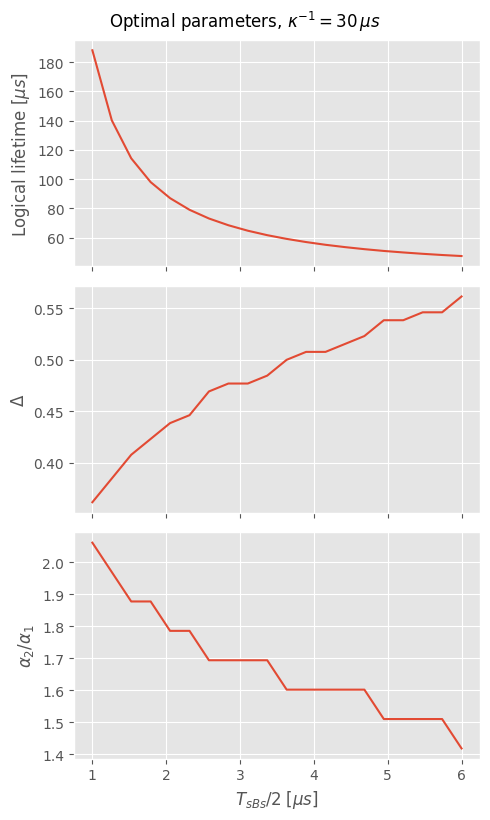

In [59]:
fig, axs = plt.subplots(3, sharex=True, figsize=(5, 8))

axs[0].plot(T_0s, max_t1s)
#axs[0].set_xlabel("$T_{sBs}/2 \;[\mu s]$")
axs[0].set_ylabel("Logical lifetime $[\mu s]$")
axs[1].plot(T_0s, max_deltas)
#axs[1].set_xlabel("$T_{sBs}/2 \;[\mu s]$")
axs[1].set_ylabel("$\Delta$")
axs[2].plot(T_0s, max_sd_ratios)
axs[2].set_xlabel("$T_{sBs}/2 \;[\mu s]$")
axs[2].set_ylabel("$\\alpha_2 / \\alpha_1$")

fig.tight_layout()
fig.suptitle(f"Optimal parameters, $\kappa^{{-1}}={1/kappa:.0f} \,\mu s$", y=1.02)

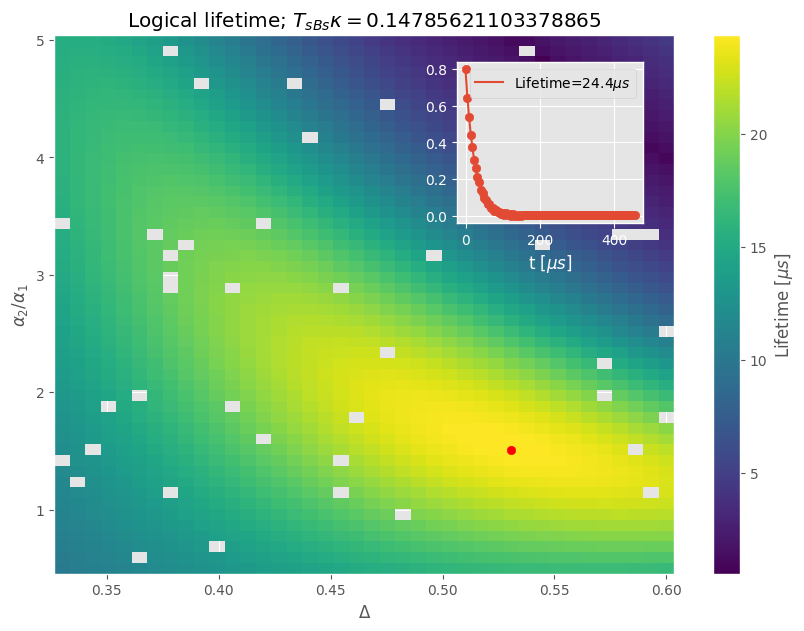

In [31]:
fig, ax = plt.subplots(1, figsize=(10, 7))
handle = ax.pcolormesh(deltas_mg, sd_ratios_mg, masked_t1s, shading='nearest')
fig.colorbar(handle, ax=ax, label="Lifetime $[\mu s]$")
ax.scatter(max_t1_delta, max_t1_sd_ratio, color='red')
ax.set_xlabel(r"$\Delta$")
ax.set_ylabel(r"$\alpha_2 / \alpha_1$")
ax.set_title(f"Logical lifetime; $T_{{sBs}}\kappa={err_prob}$")
inset_ax = ax.inset_axes([0.65, 0.65, 0.30, 0.30])
inset_ax.scatter(times, results[max_t1_idx])
inset_ax.set_xlabel("t $[\mu s]$")
fit_f = coeff[max_t1_idx][0]*jnp.exp(coeff[max_t1_idx][1]*times)
inset_ax.xaxis.label.set_color('white')
inset_ax.tick_params(axis='x', colors='white')
inset_ax.yaxis.label.set_color('white')
inset_ax.tick_params(axis='y', colors='white')
inset_ax.plot(times, fit_f, label=f"Lifetime={max_t1:.1f}$\\mu s$")
inset_ax.legend()

## Export best sBs sequence

In [ ]:
delta = max_t1_delta
sd_ratio = max_t1_sd_ratio

In [ ]:
l = jnp.sqrt(2*jnp.pi)
epsilon = jnp.sinh(delta*delta)*l

alphas_real = jnp.array([epsilon/2, 0., sd_ratio*epsilon/2, 0., l, 0.])
alphas_imag = jnp.array([0., -l, 0., epsilon/2, 0., sd_ratio*epsilon/2])
phis = jnp.array([jnp.pi/2, 0., 0., jnp.pi/2, 0., 0.]) / 2 / jnp.pi
thetas = (jnp.array([jnp.pi, jnp.pi/2, -jnp.pi/2, jnp.pi, jnp.pi/2, -jnp.pi/2])-jnp.pi) / 2 / jnp.pi

In [ ]:
sbs_max_LL_Z = jnp.array([thetas[0:3], phis[0:3], alphas_real[0:3], alphas_imag[0:3]])
sbs_max_LL_X = jnp.array([thetas[3:6], phis[3:6], alphas_real[3:6], alphas_imag[3:6]])